In [ ]:
!pip install mne scipy
!pip install pyqt5

import scipy.io
import numpy as np
import matplotlib
import mne
import os
import pathlib
import pandas as pd
import shutil
from pathlib import Path

matplotlib.use('Agg')

from tensorflow.keras.models import load_model
from sklearn.svm import SVC
import pickle

from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-model-1.keras'
cnn_model = load_model(model_save_path)

svm_model_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-svm_model.pkl'
from joblib import load
svm_model = load(svm_model_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 19.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# upload the file and input the user name

from google.colab import files
uploaded_files = files.upload()

input_username = input("Username: ")

Saving epoch002291.fif to epoch002291 (1).fif
Enter your username (e.g., sub001, sub002): sub004


Processing file: epoch002291 (1).fif
Opening raw data file epoch002291 (1).fif...
Isotrak not found
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Reading 0 ... 999  =      0.000 ...     3.996 secs...
Plotting raw data with event markers...
1 event found on stim channel Marker
Event IDs: [3]


<ipython-input-12-9e1103e60438>:14: RuntimeWarning: This filename (epoch002291 (1).fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True)


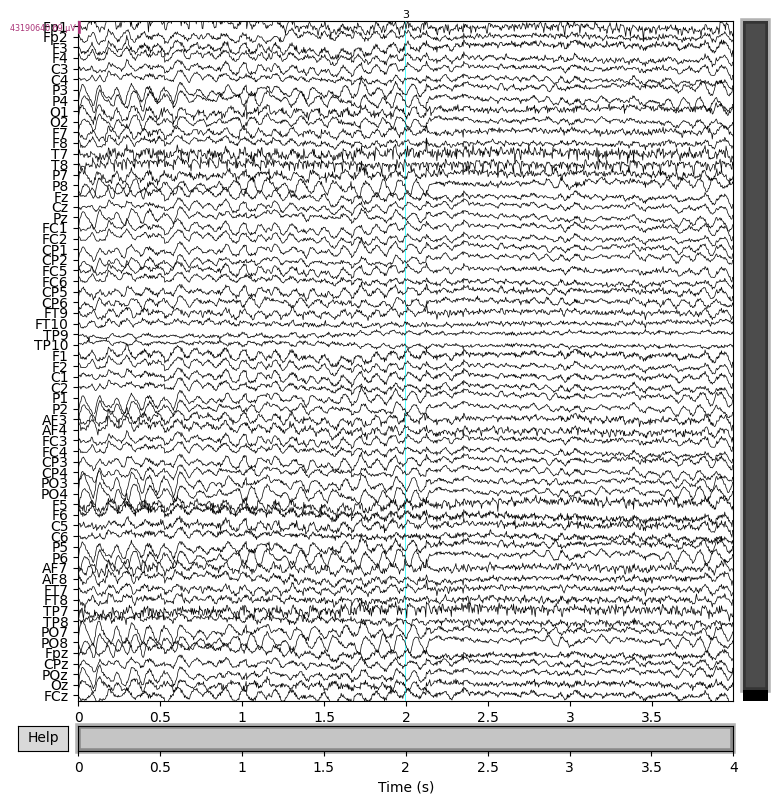

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Plotting filtered data with event markers...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


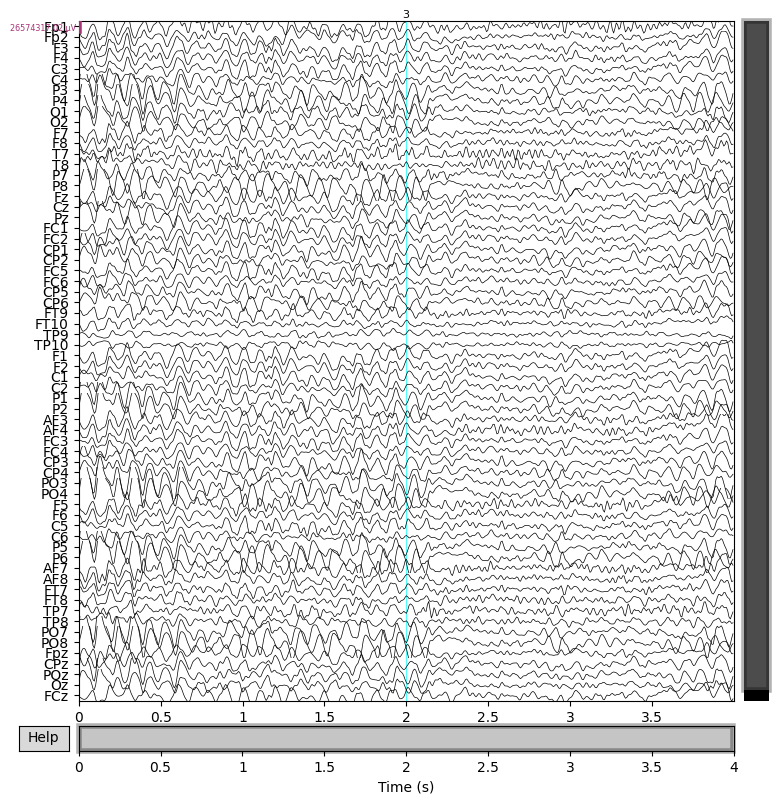

Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 251 original time points ...
0 bad epochs dropped
Plotting epochs with event markers...


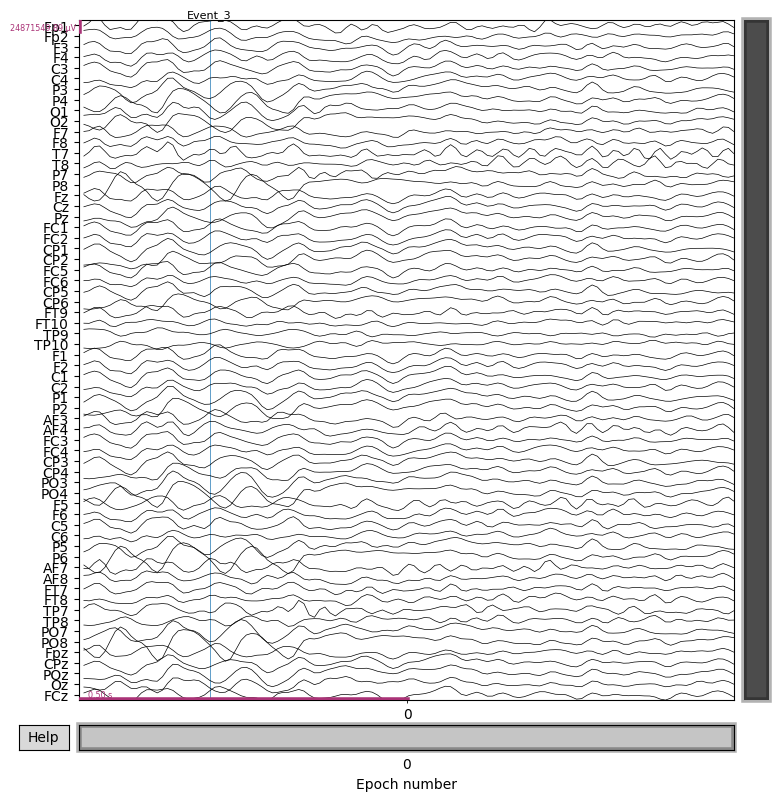

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted subject for epoch002291 (1).fif: sub004 with 63.53% confidence
Authentication status: User authenticated


In [ ]:
%matplotlib inline
import mne
from sklearn.svm import SVC
from scipy.special import softmax
import matplotlib.pyplot as plt

predictions = []
confidences = []

for filename in uploaded_files.keys():
    fif_path = filename

    raw = mne.io.read_raw_fif(fif_path, preload=True)

    raw.set_channel_types({'Marker': 'stim'})
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage)

    events = mne.find_events(raw, stim_channel='Marker')
    raw.plot(n_channels=64, scalings='auto', events=events, title=f"Raw EEG Data with Events: {filename}", show=True, block=True)

    raw.filter(l_freq=1.0, h_freq=30.0)

    print("Plotting filtered data with event markers...")
    raw.plot(n_channels=64, scalings='auto', events=events, title=f"Filtered EEG Data with Events: {filename}", show=True, block=True)

    unique_event_id = events[0, 2]
    event_id = {f"Event_{unique_event_id}": unique_event_id}

    tmin = -0.2
    tmax = 0.8
    baseline = (None, 0)
    epochs = mne.Epochs(raw,
                        events=events,
                        event_id=event_id,
                        tmin=tmin,
                        tmax=tmax,
                        baseline=baseline,
                        preload=True)

    # Visualize epochs
    print("Plotting epochs with event markers...")
    epochs.plot(n_channels=64, scalings='auto', events=events, event_id=event_id, title="Epochs with Event Markers", block=True)

    eeg_data = epochs.get_data()[:, :64, :]

    cnn_features = cnn_model.predict(eeg_data)
    cnn_features = cnn_features.reshape(cnn_features.shape[0], -1)

    svm_decision_scores = svm_model.decision_function(cnn_features)
    probabilities = softmax(svm_decision_scores, axis=1)
    predicted_class = np.argmax(probabilities, axis=1)[0]
    confidence_score = np.max(probabilities, axis=1)[0] * 100

    predicted_subject = f"sub{predicted_class + 1:03d}"

    predictions.append(predicted_subject)
    confidences.append(confidence_score)

    # Authentication status
    if input_username == predicted_subject:
        status = "User authenticated"
    else:
        status = "User rejected"

    print(f"Predicted subject for {filename}: {predicted_subject} with {confidence_score:.2f}% confidence")
    print(f"Authentication status: {status}")
